In [8]:
import requests
import numpy as np
import pandas as pd
import os


# Función para obtener datos históricos de una criptomoneda
def obtener_datos_historicos(criptomoneda):
    url = f"https://api.binance.com/api/v3/klines?symbol={criptomoneda}USDT&interval=1d&limit=1000"
    respuesta = requests.get(url)
    datos = respuesta.json()
    
    # Extraer los datos relevantes: Fecha, Precio de cierre, Volumen, Cap. de mercado (lo aproximamos usando el precio de cierre por volumen)
    fechas = [item[0] for item in datos]
    precios_cierre = [float(item[4]) for item in datos]
    volumenes = [float(item[7]) for item in datos]
    cap_mercado = [precio * volumen for precio, volumen in zip(precios_cierre, volumenes)]
    
    df = pd.DataFrame({
        'Fecha': fechas,
        'Precio_Cierre': precios_cierre,
        'Volumen_24h': volumenes,
        'Cap_Mercado': cap_mercado
    })
    
    return df


def obtener_nombre_completo(symbol):
    url = f"https://api.binance.com/api/v3/exchangeInfo"
    respuesta = requests.get(url)
    data = respuesta.json()

    for coin_info in data['symbols']:
        if coin_info['symbol'] == f"{symbol}USDT":
            # Aquí deberías cambiar 'baseAssetName' por el campo correcto después de inspeccionar la respuesta
            return coin_info['baseAsset']  
    return None



# Función para calcular la volatilidad de 30 días
def calcular_volatilidad(precios):
    rendimientos = np.diff(np.log(precios))
    volatilidad = np.std(rendimientos) 
    return volatilidad

# Lista de criptomonedas
criptomonedas = ["BTC", "ETH", "XRP", "MATIC", "SOL", "ADA", "DOGE", "BNB", "DOT"]

# Diccionario para almacenar dataframes por criptomoneda
dataframes = {}

for moneda in criptomonedas:
    df = obtener_datos_historicos(moneda)
    
    # Calcular la volatilidad para cada fila del DataFrame y agregarla como nueva columna
    df['Volatilidad_30d'] = df['Precio_Cierre'].rolling(window=30).apply(calcular_volatilidad).round(3)

    df.fillna(0, inplace=True)

    # Convertir la columna de fecha en formato Unix a formato datetime
    df['Fecha'] = pd.to_datetime(df['Fecha'], unit='ms')

    # Convertir la fecha al formato deseado YY/MM/DD
    df['Fecha'] = df['Fecha'].dt.strftime('%y/%m/%d')

    # Guardar el DataFrame en el diccionario
    dataframes[moneda] = df
    
def transformar_formato(numero):
    """Transforma un número a formato legible con separación de miles por punto y decimales con coma."""
    return '{:,.2f}'.format(numero).replace(',', 'x').replace('.', ',').replace('x', '.')

def transformar_formato_al_original(numero):
    """Transforma str legible numericamente con miles con punto y decimales con coma, al formato original y hacerlo float"""
    numero = numero.replace('.', '').replace(',', '.')
    return float(numero)


for moneda, df in dataframes.items():
    # Transformar 'Volumen_24h'
    df['Volumen_24h'] = df['Volumen_24h'].apply(transformar_formato)
    
    # Transformar 'Cap_Mercado'
    df['Cap_Mercado'] = df['Cap_Mercado'].apply(transformar_formato)
    
        # Transformar 'Precio_Cierre'
    df['Precio_Cierre'] = df['Precio_Cierre'].apply(transformar_formato)
    


    nombre_completo = obtener_nombre_completo(moneda)
    
    if nombre_completo:
        with open(f"{nombre_completo}.csv", "w") as file:
            # Escribir las cabeceras
            cabeceras = ["Fecha", "Precio_Cierre", "Volumen_24h", "Cap_Mercado", "Volatilidad_30d"]
            file.write(",".join(cabeceras) + "\n")

            # Escribir cada fila manualmente excepto la última
            for _, row in df[:-1].iterrows():
                valores = [str(val) for val in row]
                file.write(",".join(valores) + "\n")
            
            # Escribir la última fila sin el salto de línea al final
            valores = [str(val) for val in df.iloc[-1]]
            file.write(",".join(valores))
    
        # Transformar 'Volumen_24h'
    df['Volumen_24h'] = df['Volumen_24h'].apply(transformar_formato_al_original)
    
    # Transformar 'Cap_Mercado'
    df['Cap_Mercado'] = df['Cap_Mercado'].apply(transformar_formato_al_original)
    
        # Transformar 'Precio_Cierre'
    df['Precio_Cierre'] = df['Precio_Cierre'].apply(transformar_formato_al_original)
    
    """aqui haremos parte del ETL:

    Para columnas numéricas:

    count: número de valores no nulos.
    mean: media aritmética.
    std: desviación estándar.
    min: valor mínimo.
    25%: percentil 25.
    50%: mediana o percentil 50.
    75%: percentil 75.
    max: valor máximo.

    Para columnas no numéricas (por ejemplo, tipo object o categorial):

    count: número de valores no nulos.
    unique: número de valores únicos.
    top: valor más común.
    freq: frecuencia del valor más común."""

    print("-----------------------------")
    print(moneda)
    print("-----------------------------")
    print(df.info())
    print("-----------------------------")
    print(df.describe(include="all"))
    print("--------------------------------------------------------")
     
# Aquí, dataframes es un diccionario donde las claves son los nombres de las criptomonedas y 
# los valores son DataFrames con las columnas 'Fecha', 'Precio_Cierre', 'Volumen_24h', 'Cap_Mercado' y 'Volatilidad_30d'.
dataframes['SOL']



-----------------------------
BTC
-----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Fecha            1000 non-null   object 
 1   Precio_Cierre    1000 non-null   float64
 2   Volumen_24h      1000 non-null   float64
 3   Cap_Mercado      1000 non-null   float64
 4   Volatilidad_30d  1000 non-null   float64
dtypes: float64(4), object(1)
memory usage: 39.2+ KB
None
-----------------------------
           Fecha  Precio_Cierre   Volumen_24h   Cap_Mercado  Volatilidad_30d
count       1000    1000.000000  1.000000e+03  1.000000e+03      1000.000000
unique      1000            NaN           NaN           NaN              NaN
top     20/11/29            NaN           NaN           NaN              NaN
freq           1            NaN           NaN           NaN              NaN
mean         NaN   34550.990380  3.1

,Fecha,Precio_Cierre,Volumen_24h,Cap_Mercado,Volatilidad_30d
0,20/11/29,1.92,1640192.47,3.141461e+06,0.000
1,20/11/30,1.97,2153816.63,4.235480e+06,0.000
2,20/12/01,1.97,4264962.99,8.418184e+06,0.000
3,20/12/02,2.12,4622524.29,9.803912e+06,0.000
4,20/12/03,2.10,6879026.85,1.442326e+07,0.000
...,...,...,...,...,...
995,23/08/21,21.20,55880117.16,1.184658e+09,0.031
996,23/08/22,20.59,74265939.70,1.529136e+09,0.030
997,23/08/23,21.74,78082936.83,1.697523e+09,0.031
998,23/08/24,21.06,58030701.12,1.222127e+09,0.028


<strong>ETL: aqui realizo el análisis exploratorio visual y la detección de valores atípicos (outliers) de ciertos atributos de diferentes criptomonedas.</strong><br>

Importación de bibliotecas:<br>

matplotlib: para la visualización de gráficos.<br>
seaborn: otra herramienta de visualización que se construye sobre matplotlib y permite gráficos más atractivos y estadísticamente informados.<br>
scipy.stats: para obtener las puntuaciones Z (z-scores), que se usarán para la detección de outliers.<br>
numpy: para operaciones matemáticas y de arreglo.<br>

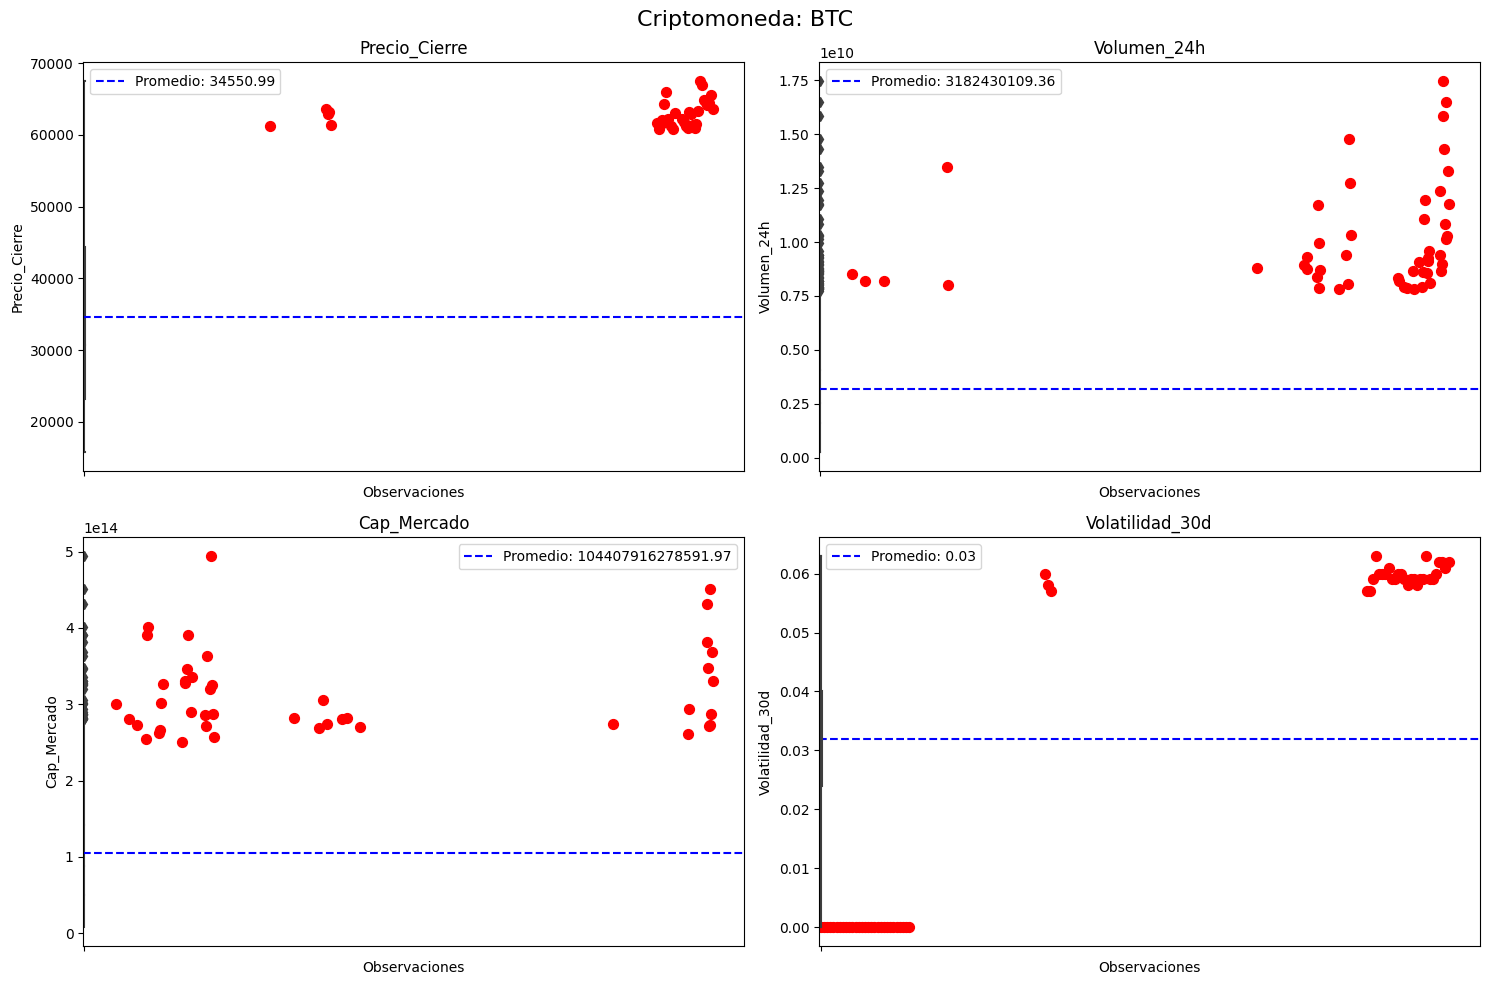

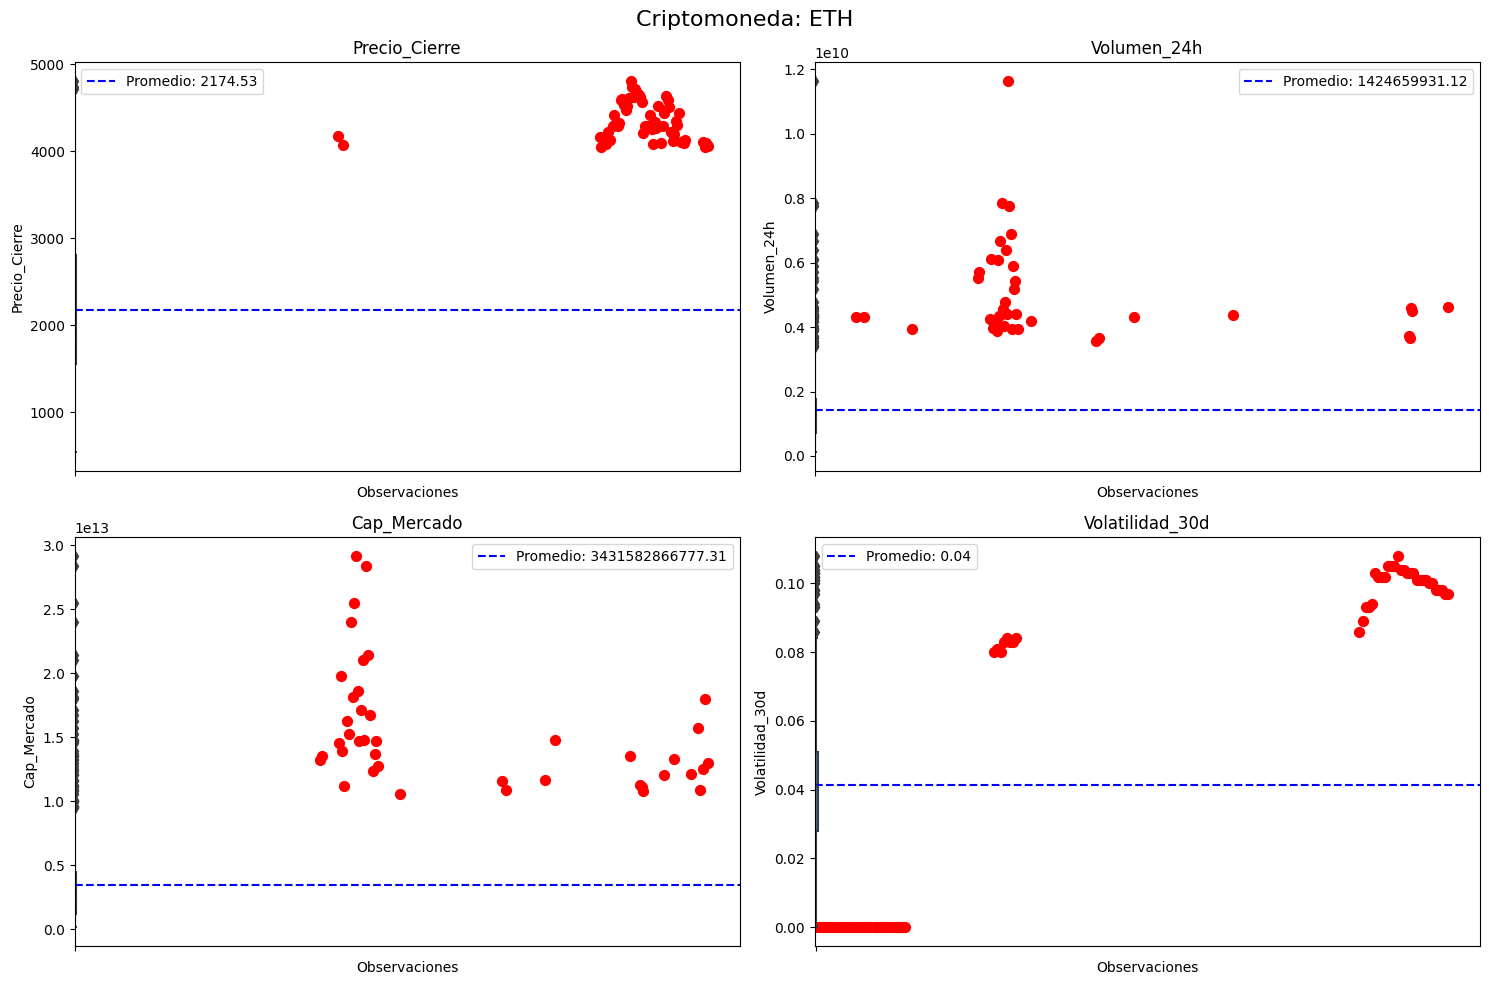

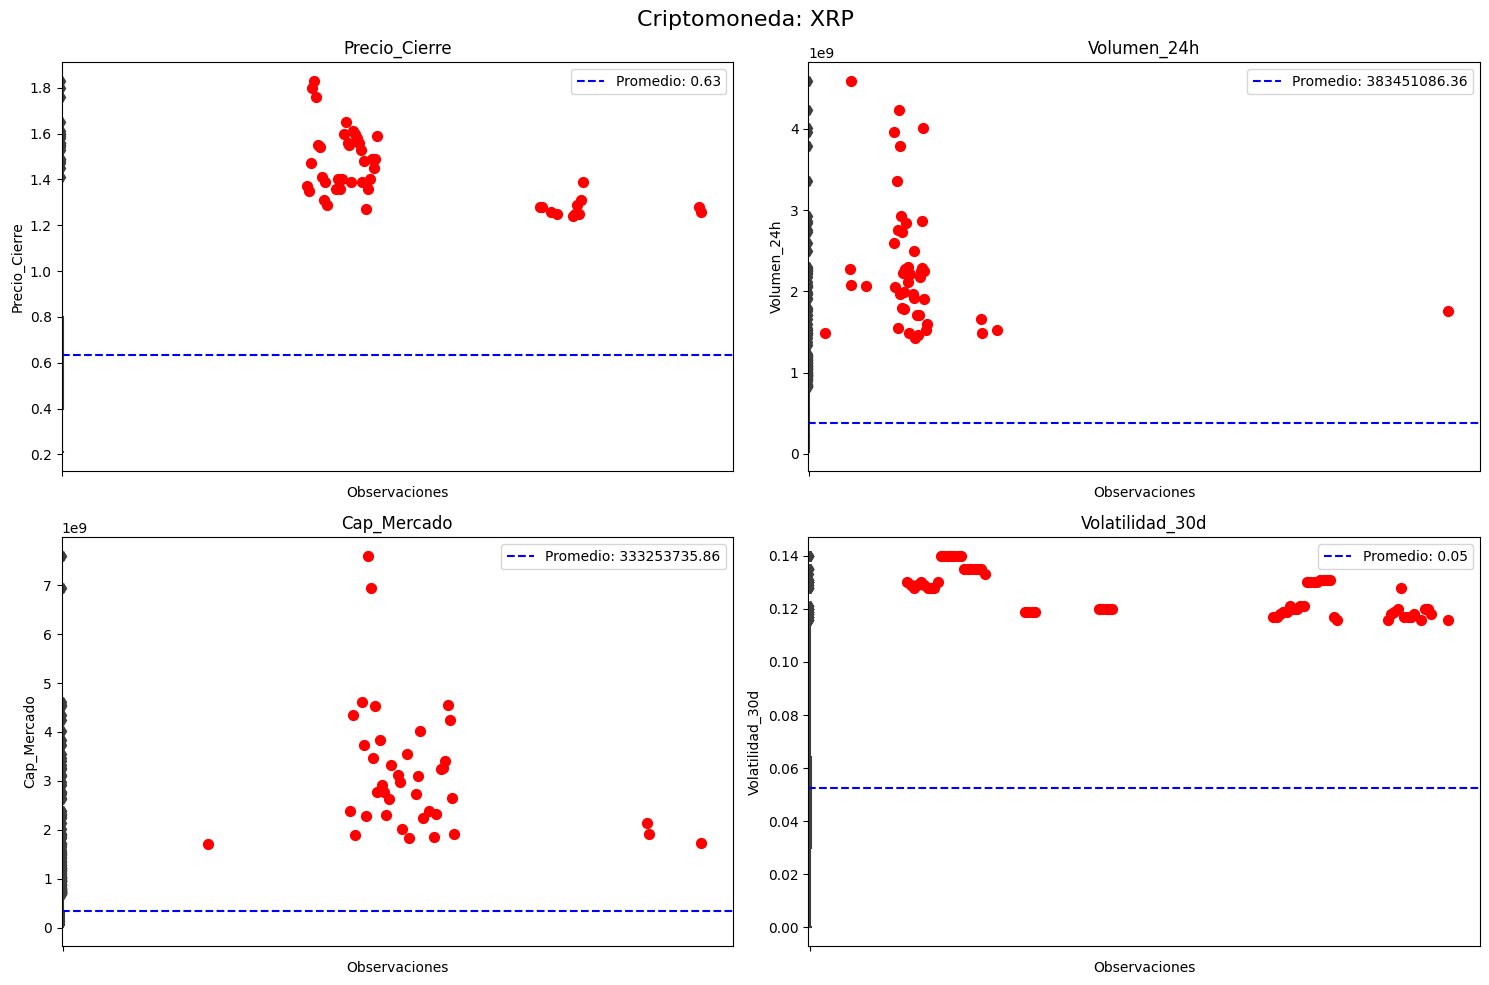

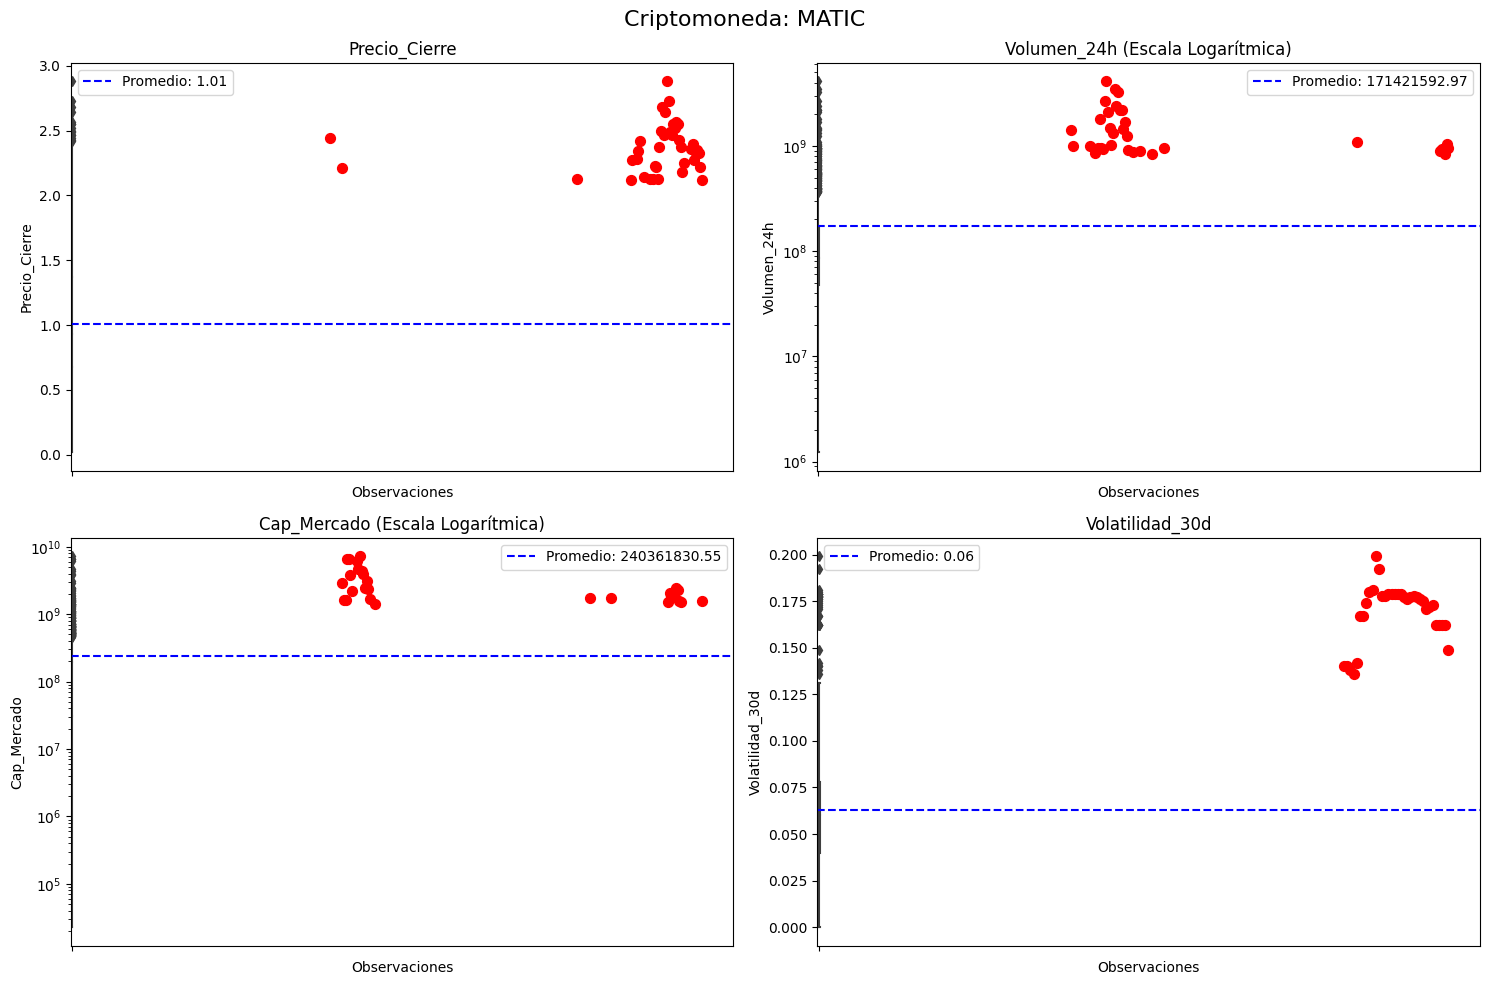

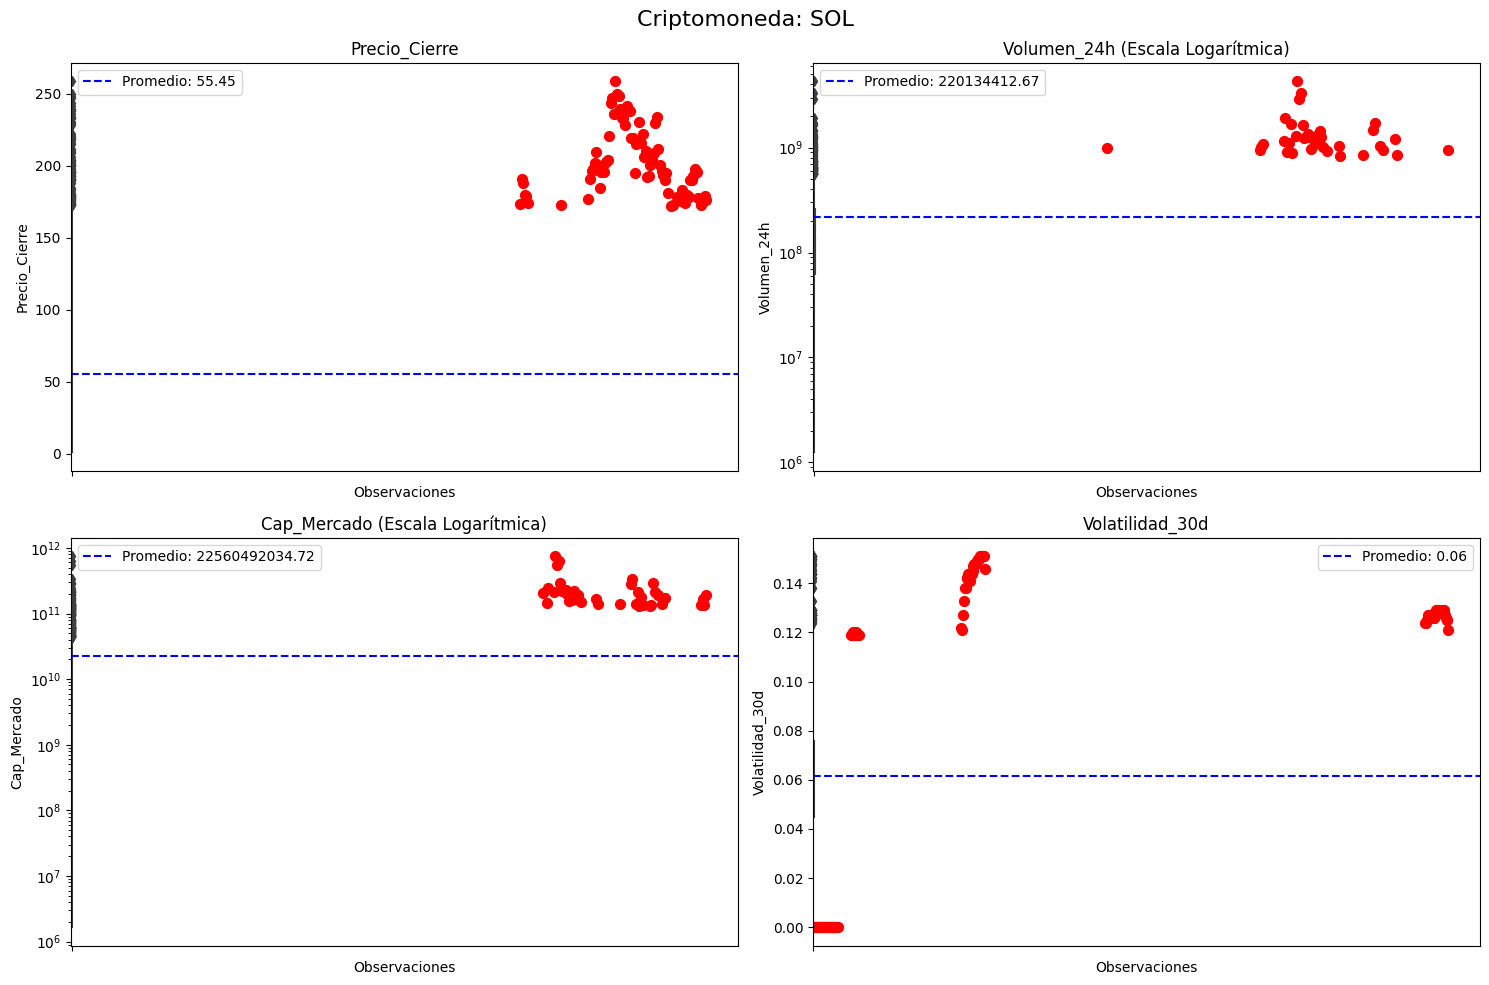

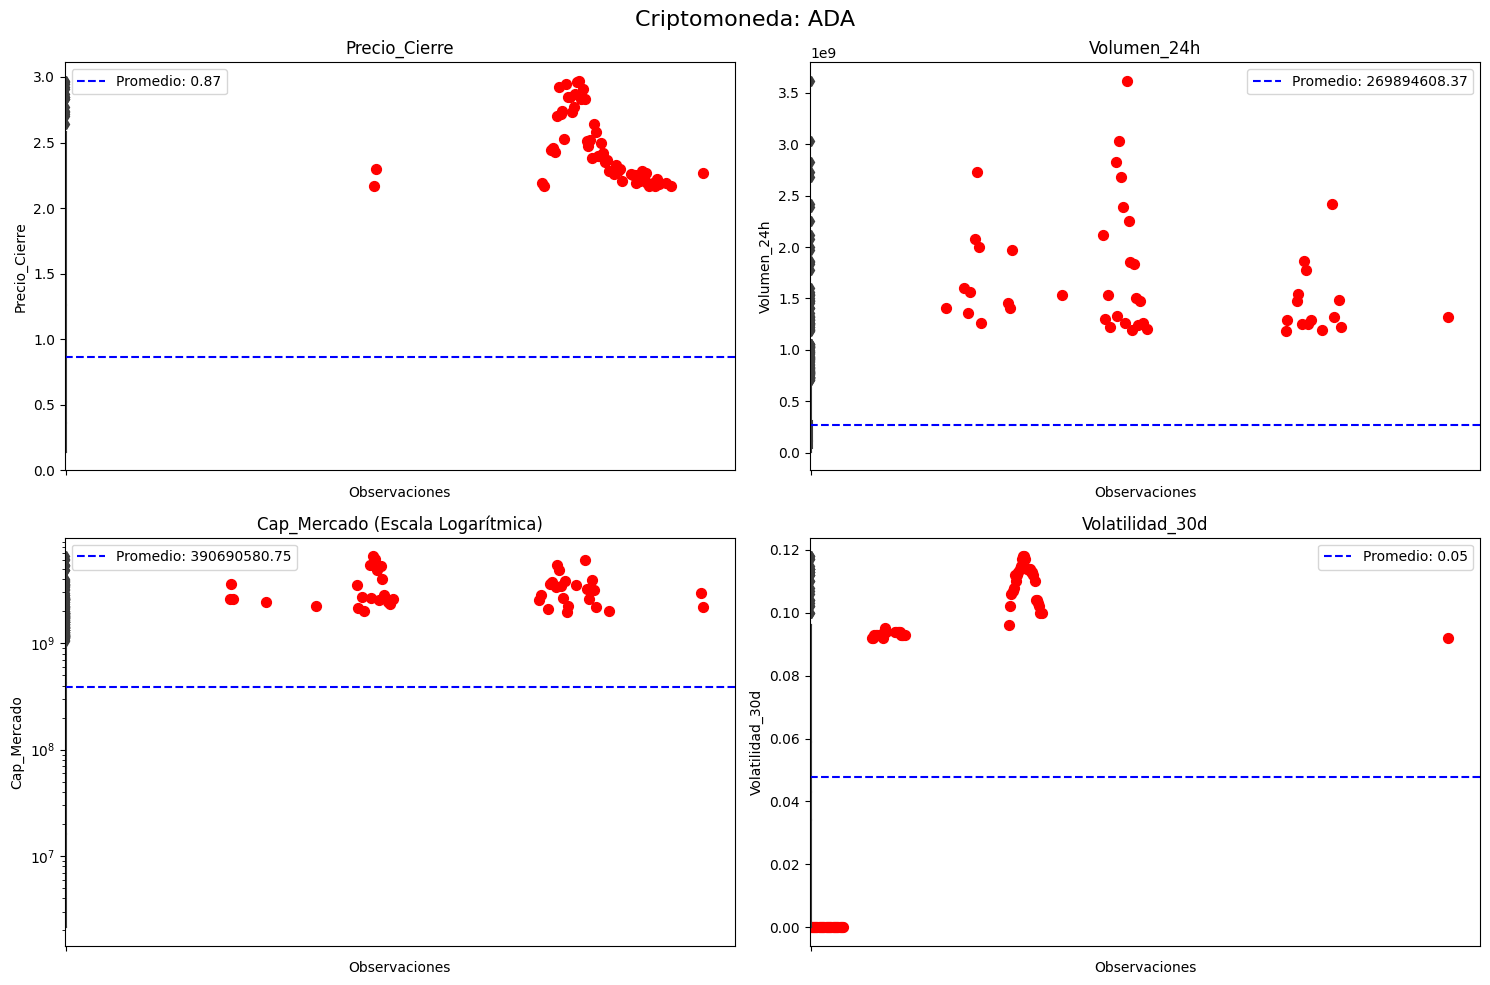

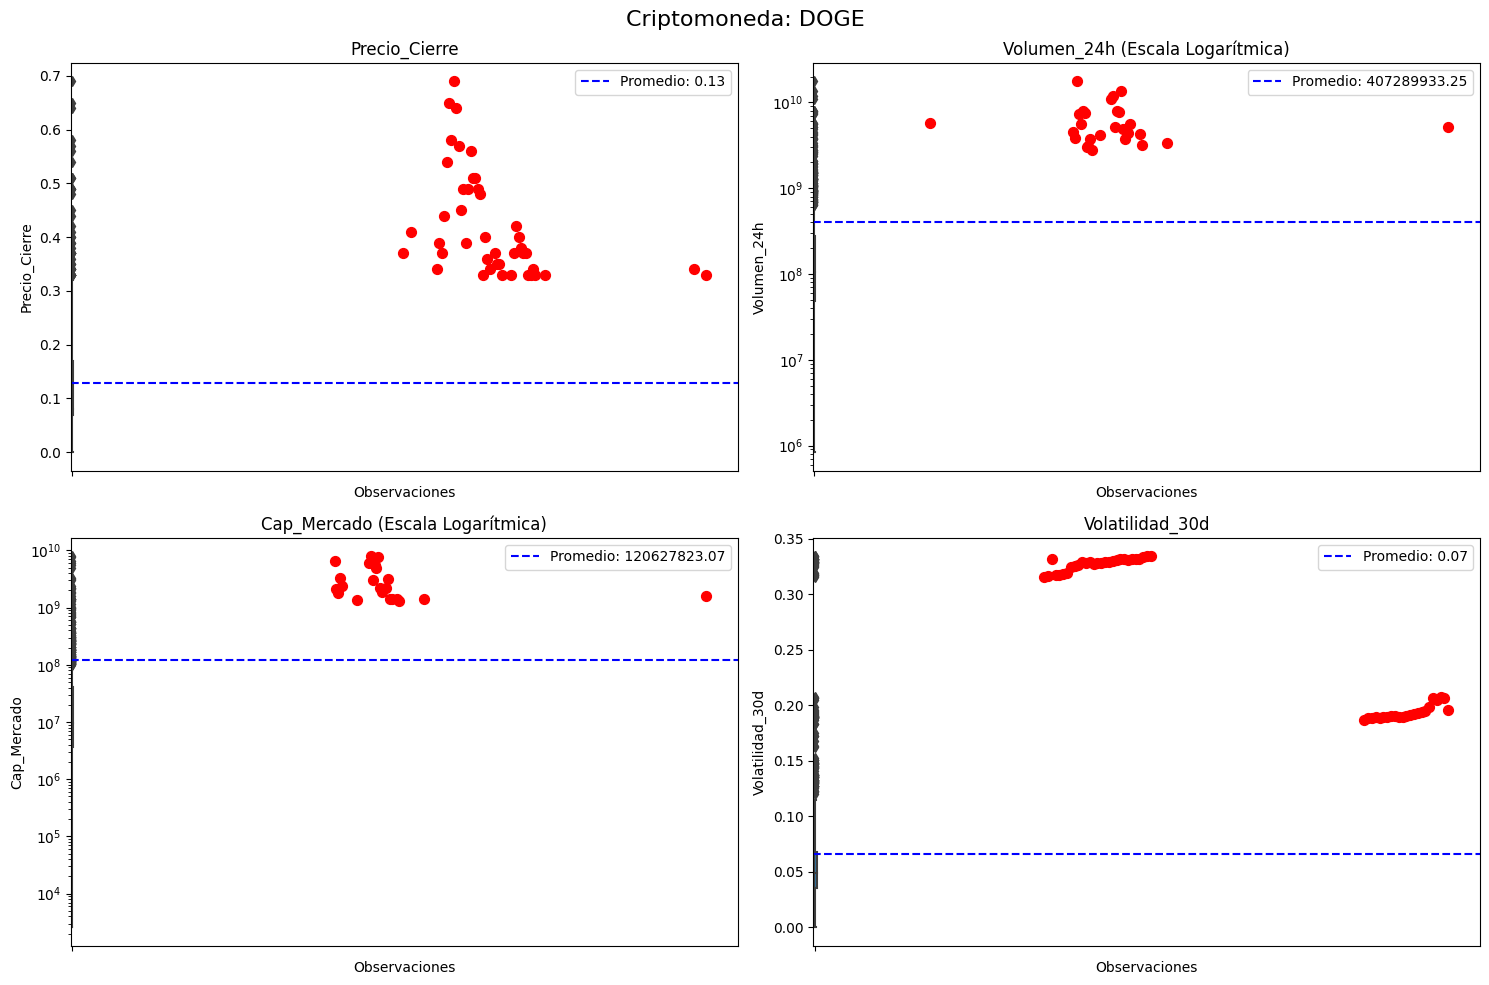

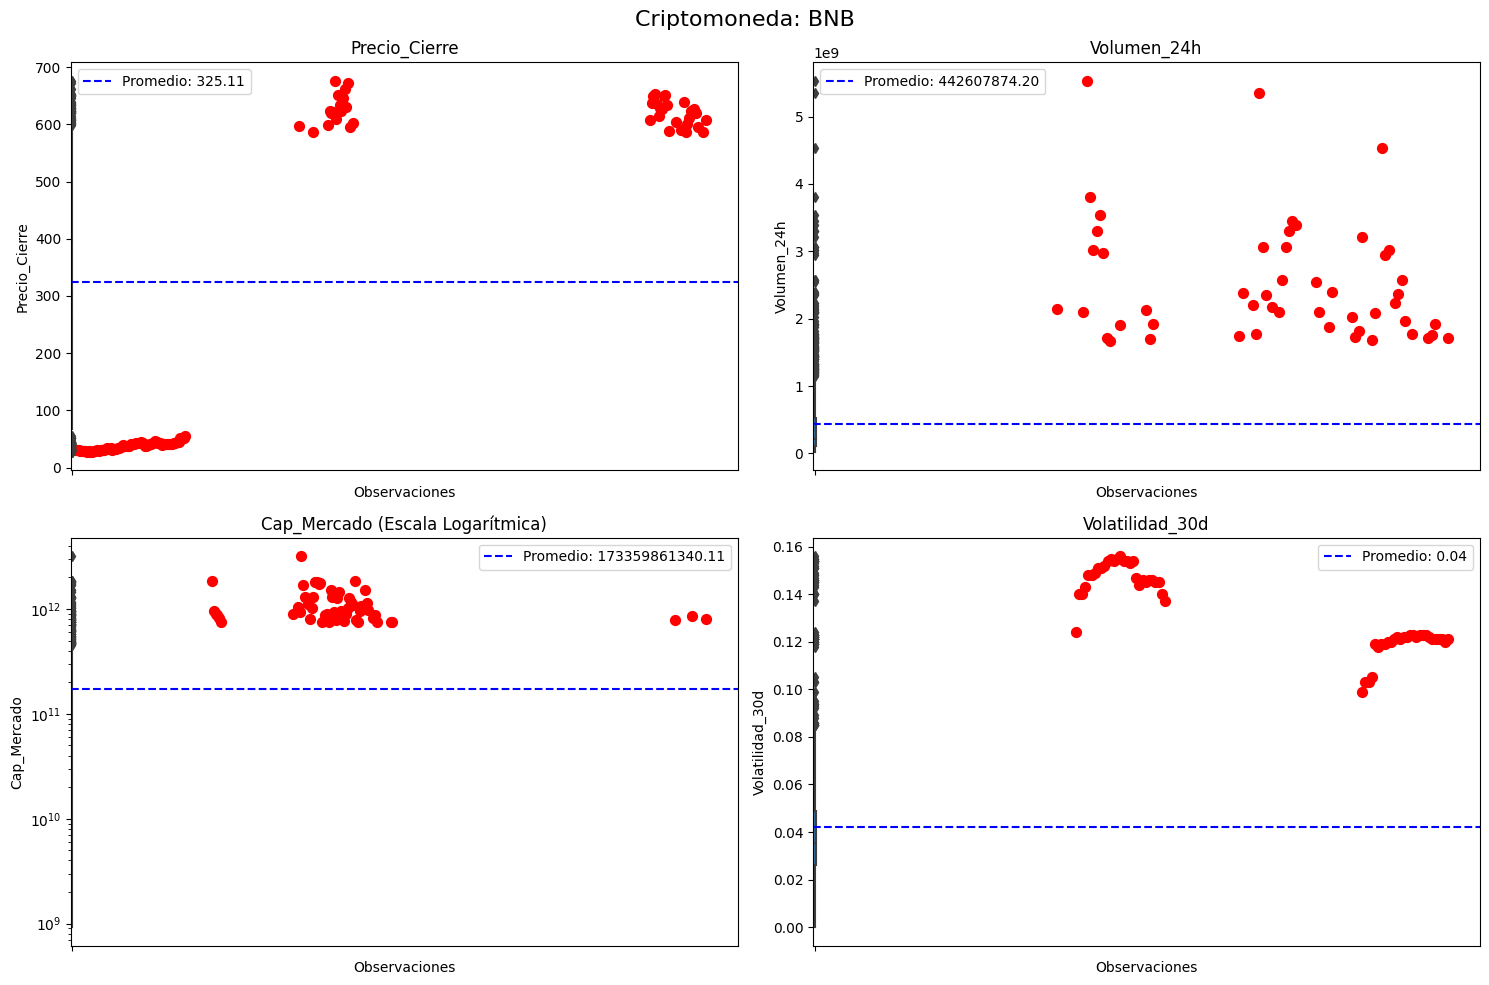

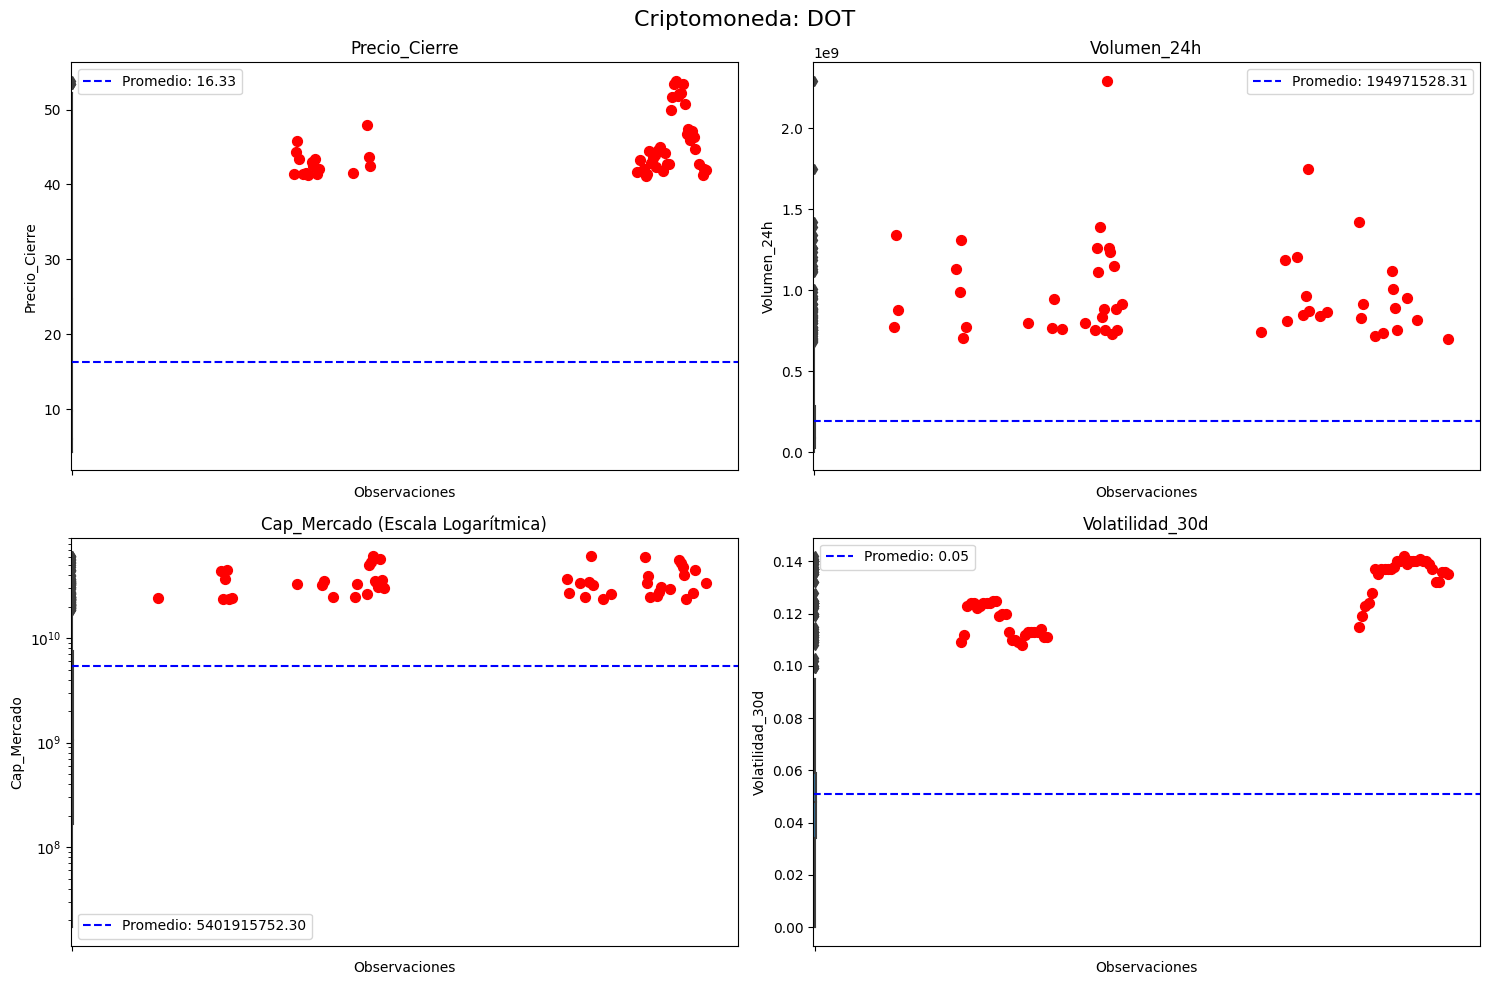

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

# Lista de columnas a analizar
columns_to_analyze = ['Precio_Cierre', 'Volumen_24h', 'Cap_Mercado', 'Volatilidad_30d']

for moneda, df in dataframes.items(): 
    
    # Convertir las columnas a numéricas y reemplazar valores no numéricos con 0
    for column in ['Volumen_24h', 'Cap_Mercado', 'Precio_Cierre']:
        df[column] = pd.to_numeric(df[column], errors='coerce')
        df[column].fillna(0, inplace=True)
    
    plt.figure(figsize=(15, 10))
    
    for i, column in enumerate(columns_to_analyze, 1):
        z_scores = stats.zscore(df[column])
        abs_z_scores = np.abs(z_scores)
        outliers = df[(abs_z_scores > 2)]
        
        ax = plt.subplot(2, 2, i)  # Creando 4 subplots: 2 filas y 2 columnas
        
        sns.boxplot(y=df[column], ax=ax)  # Nota: Cambiamos el boxplot para ser vertical
        
        # Agregar una línea horizontal para el valor promedio
        avg_value = df[column].mean()
        ax.axhline(y=avg_value, color='blue', linestyle='--', label=f"Promedio: {avg_value:.2f}")
        
        # Establecer escala logarítmica si los datos varían en varios órdenes de magnitud
        if df[column].min() > 0 and df[column].max() / df[column].min() > 1000:
            ax.set_yscale("log")
            plt.title(f"{column} (Escala Logarítmica)")
        else:
            plt.title(column)
        
        plt.xlabel("Observaciones")
        plt.ylabel(column)
        plt.scatter(outliers.index, outliers[column], color='red', s=50)  # Marca outliers en rojo
        plt.legend()  # Mostrar leyenda para el valor promedio
        
    # Mostrar información de la criptomoneda actual
    plt.suptitle(f"Criptomoneda: {moneda}", fontsize=16)
    plt.tight_layout()
    plt.show()
